In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import sympy as sp
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
jax.config.update("jax_enable_x64", True)
from tqdm import *

### THE ITERATION PARAMETERs
#physical parameters
delta = 0.024 #interface width
Lambda = jnp.sqrt(2)*delta/4
g_ca = [3e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 1.1e-2, 1.2e-2, 1.3e-2, 1.5e-2]
gamma_bc = 1e-2
gamma_ab = 1e-2  

image_num = 50
N = 128 #num of nodes
r = jnp.linspace(0, 1, N+1)
r_mid = (r[1:] + r[:-1]) / 2
dr = r_mid[1] - r_mid[0]

In [2]:
def cal_theoretical_angle(g_ca):
    gamma_ab = 1e-2
    gamma_bc = 1e-2
    x, y = sp.symbols('x y')
    eq1 = g_ca*sp.cos(x) + gamma_bc*sp.cos(y) - gamma_ab
    eq2 = gamma_bc*sp.sin(y) - g_ca*sp.sin(x)
    solution = sp.solve([eq1, eq2], (x, y))
    angle = solution[-1]
    return angle

def cal_shapefactor1(Angle):
    theta = float(Angle[0])
    phi = float(Angle[1])
    s1 = (2+jnp.cos(theta))*jnp.power(1-jnp.cos(theta), 2)/4
    s2 = (2+jnp.cos(phi))*(1-jnp.cos(phi))*jnp.power(jnp.sin(theta), 3)
    s3 = 4*(1+jnp.cos(phi))*jnp.sin(phi)
    S = s1 + (s2/s3)
    return S

def cal_shapefactor2(Angle):
    phi = float(Angle[0])
    theta = float(Angle[1])
    s1 = (2+jnp.cos(theta))*jnp.power(1-jnp.cos(theta), 2)/4
    s2 = (2+jnp.cos(phi))*(1-jnp.cos(phi))*jnp.power(jnp.sin(theta), 3)
    s3 = 4*(1+jnp.cos(phi))*jnp.sin(phi)
    S = s1 + (s2/s3)
    return S

sf = []
for gamma_ca in g_ca:
    angle = cal_theoretical_angle(g_ca=gamma_ca)
    if gamma_ca < 1e-2: sf.append(float(cal_shapefactor1(Angle=angle)))
    else: sf.append(float(cal_shapefactor2(Angle=angle)))

print(sf)

[0.4437500000000001, 0.40625, 0.3875000000000001, 0.36874999999999997, 0.34999999999999987, 0.33124999999999993, 0.3125, 0.39098125, 0.47519999999999996, 0.56298125, 0.73828125]


In [3]:
@jax.jit
def cal_gradsquare(x, nn=0, corrected=False):

    if corrected: k = 2*jnp.pi*jnp.fft.fftfreq(N-2*nn, d=dr)
    else: k = 2*jnp.pi*jnp.fft.fftfreq(N, d=dr)
    kx, ky, kz = jnp.meshgrid(k, k, k)
    k_square = kx**2 + ky**2 + kz**2
    xh = jnp.fft.fftn(x, axes=(1,2,3))
    #px = jnp.fft.ifftn(kx*1j*xh, axes=(1,2,3)).real
    #py = jnp.fft.ifftn(ky*1j*xh, axes=(1,2,3)).real
    #pz = jnp.fft.ifftn(kz*1j*xh, axes=(1,2,3)).real
    #return px**2 + py**2 + pz**2
    p = jnp.fft.ifftn(k_square*xh, axes=(1,2,3)).real
    return x*p


In [4]:

def main(case, corrected=False):
    eb = []
    for gamma_ca in tqdm(g_ca):
        if gamma_ca>1e-2:
            Ac = (9*gamma_ca + 12*(gamma_bc - gamma_ab))/(4*jnp.sqrt(2)*Lambda)
            Aa = (9*gamma_ca - 12*(gamma_bc - gamma_ab))/(4*jnp.sqrt(2)*Lambda)
            Ab = 3*jnp.sqrt(2)*gamma_bc/Lambda - 4*Ac/3 - Aa/3 
        else:
            Ab = jnp.sqrt(2)*(9*gamma_bc + 12*(gamma_ab - gamma_ca))/(8*Lambda)
            Ac = jnp.sqrt(2)*(9*gamma_bc - 12*(gamma_ab - gamma_ca))/(8*Lambda)
            Aa = 3*jnp.sqrt(2)*gamma_ab/Lambda - 4*Ab/3 - Ac/3
        A = jnp.array([Aa, Ab, Ac])
        C = jnp.max(A + jnp.roll(A, 1))/6

        u = jnp.load(f"Nucleation_ZTS/TernaryMix/3d/Output/AsymmetricCase/Data-InterfaceWidth-0.024/gamma_ac-{gamma_ca}/{case}/concentration.npy")
        if not corrected:
            ua = u[0]
            ub = u[1]
            uc = u[2]
            
            bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
            
            Wa = jnp.power(Lambda, 2)*(Aa + C)
            Wb = jnp.power(Lambda, 2)*(Ab + C)
            Wc = jnp.power(Lambda, 2)*(Ac + C)

            interface_term = Wa*cal_gradsquare(ua)/2 + Wb*cal_gradsquare(ub)/2 + Wc*cal_gradsquare(uc)/2

            G = jnp.mean(bulk_term + interface_term, axis=(1,2,3))
            critical_index = jnp.argmax(G)
            barrier = G[critical_index] - G[0]
            eb.append(float(barrier))
        else:
            nn = 8
            #ua = u[0, :, nn:N-nn+1, nn:N-nn+1, nn:N-nn+1]
            #ub = u[1, :, nn:N-nn+1, nn:N-nn+1, nn:N-nn+1]
            #uc = u[2, :, nn:N-nn+1, nn:N-nn+1, nn:N-nn+1]
            ua = u[0, :, nn:N-nn, nn:N-nn, nn:N-nn]
            ub = u[1, :, nn:N-nn, nn:N-nn, nn:N-nn]
            uc = u[2, :, nn:N-nn, nn:N-nn, nn:N-nn]

            bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
            
            Wa = jnp.power(Lambda, 2)*(Aa + C)
            Wb = jnp.power(Lambda, 2)*(Ab + C)
            Wc = jnp.power(Lambda, 2)*(Ac + C)

            interface_term = Wa*cal_gradsquare(ua, nn=nn, corrected=True)/2 + Wb*cal_gradsquare(ub, nn=nn, corrected=True)/2 + Wc*cal_gradsquare(uc, nn=nn, corrected=True)/2

            G = jnp.mean(bulk_term + interface_term, axis=(1,2,3))
            critical_index = jnp.argmax(G)
            barrier = G[critical_index] - G[0]
            eb.append(float(barrier))

    return eb

eb_het = main(case="heterogeneous", corrected=False)
#eb_hom = main(case="homogeneous")
print(f"Het:{eb_het}")
#print(f"Hom:{eb_hom}")

100%|██████████| 11/11 [00:56<00:00,  5.14s/it]

Het:[2.0288548258133587e-05, 3.4045097661986046e-05, 4.187385423336937e-05, 5.017986018807097e-05, 5.903260660921478e-05, 7.474404681726346e-05, 8.796129612822015e-05, 9.640244337073833e-05, 9.733913984819736e-05, 0.00010689451332963201, 0.0001279003314192534]


In [5]:
def main2(case, corrected=False):
    eb = []
    for gamma_ca in tqdm(g_ca):
        if gamma_ca>1e-2:
            Ac = (9*gamma_ca + 12*(gamma_bc - gamma_ab))/(4*jnp.sqrt(2)*Lambda)
            Aa = (9*gamma_ca - 12*(gamma_bc - gamma_ab))/(4*jnp.sqrt(2)*Lambda)
            Ab = 3*jnp.sqrt(2)*gamma_bc/Lambda - 4*Ac/3 - Aa/3 
        else:
            Ab = jnp.sqrt(2)*(9*gamma_bc + 12*(gamma_ab - gamma_ca))/(8*Lambda)
            Ac = jnp.sqrt(2)*(9*gamma_bc - 12*(gamma_ab - gamma_ca))/(8*Lambda)
            Aa = 3*jnp.sqrt(2)*gamma_ab/Lambda - 4*Ab/3 - Ac/3
        A = jnp.array([Aa, Ab, Ac])
        C = jnp.max(A + jnp.roll(A, 1))/6

        u = jnp.load(f"Nucleation_ZTS/TernaryMix/3d/Output/AsymmetricCase/Data-InterfaceWidth-0.024/gamma_ac-{gamma_ca}/{case}/concentration.npy")
        if not corrected:
            ua = u[0]
            ub = u[1]
            uc = u[2]
            
            bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
            
            Wa = jnp.power(Lambda, 2)*(Aa + C)
            Wb = jnp.power(Lambda, 2)*(Ab + C)
            Wc = jnp.power(Lambda, 2)*(Ac + C)

            interface_term = Wa*cal_gradsquare(ua)/2 + Wb*cal_gradsquare(ub)/2 + Wc*cal_gradsquare(uc)/2

            G = jnp.mean(bulk_term + interface_term, axis=(1,2,3))
            critical_index = jnp.argmax(G[:30])
            barrier = G[critical_index] - G[0]
            eb.append(float(barrier))
        else:
            nn = 0
            #ua = u[0, :, nn:N-nn+1, nn:N-nn+1, nn:N-nn+1]
            #ub = u[1, :, nn:N-nn+1, nn:N-nn+1, nn:N-nn+1]
            #uc = u[2, :, nn:N-nn+1, nn:N-nn+1, nn:N-nn+1]
            ua = u[0, :, nn:N-nn, nn:N-nn, nn:N-nn]
            ub = u[1, :, nn:N-nn, nn:N-nn, nn:N-nn]
            uc = u[2, :, nn:N-nn, nn:N-nn, nn:N-nn]

            bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
            
            Wa = jnp.power(Lambda, 2)*(Aa + C)
            Wb = jnp.power(Lambda, 2)*(Ab + C)
            Wc = jnp.power(Lambda, 2)*(Ac + C)

            interface_term = Wa*cal_gradsquare(ua, nn=nn, corrected=True)/2 + Wb*cal_gradsquare(ub, nn=nn, corrected=True)/2 + Wc*cal_gradsquare(uc, nn=nn, corrected=True)/2

            G = jnp.mean(bulk_term + interface_term, axis=(1,2,3))
            critical_index = jnp.argmax(G[:30])
            barrier = G[critical_index] - G[0]
            eb.append(float(barrier))

    return eb
eb_hom = main2(case="homogeneous", corrected=False)
print(f"Hom:{eb_hom}")

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:27<00:00,  2.52s/it]

Hom:[7.630913137519207e-05, 0.00013736256479966041, 0.00017692025288890134, 0.00022440487069472909, 0.0002784414527414042, 0.00032582595547409055, 0.0003892128943211136, 0.00032714392910357035, 0.0002837830759279125, 0.0002523034254129329, 0.00021152046215831138]


In [6]:
from scipy.optimize import fsolve

g_sf_dict = dict(zip(g_ca, sf))
def cal_theo_eb_hom(g_ca):
    ## THE ITERATION PARAMETERs
    #physical parameters
    delta = 0.024 #interface width
    Lambda = jnp.sqrt(2)*delta/4
    N = 128

    gamma_ca = g_ca #interface energy between components A,B
    gamma_bc = 1e-2
    gamma_ab = 1e-2

    if gamma_ca>1e-2:
        Ac = (9*gamma_ca + 12*(gamma_bc - gamma_ab))/(4*jnp.sqrt(2)*Lambda)
        Aa = (9*gamma_ca - 12*(gamma_bc - gamma_ab))/(4*jnp.sqrt(2)*Lambda)
        Ab = 3*jnp.sqrt(2)*gamma_bc/Lambda - 4*Ac/3 - Aa/3 
    else:
        Ab = jnp.sqrt(2)*(9*gamma_bc + 12*(gamma_ab - gamma_ca))/(8*Lambda)
        Ac = jnp.sqrt(2)*(9*gamma_bc - 12*(gamma_ab - gamma_ca))/(8*Lambda)
        Aa = 3*jnp.sqrt(2)*gamma_ab/Lambda - 4*Ab/3 - Ac/3
    A = jnp.array([Aa, Ab, Ac])
    C = jnp.max(A + jnp.roll(A, 1))/6

    rc = 0.2 # the final radius of conponent C
    fai = 4*jnp.pi*jnp.power(rc,3)/3 #The mean concentration of component c
    eps = 1e-14 

    def ChemicalPotential(i, ua, ub, uc):
        P = jnp.power(1-ua, 2)*jnp.power(1-ub, 2)*jnp.power(1-uc, 2)
        S = jnp.power(ua, 2)+jnp.power(ub, 2)+jnp.power(uc, 2)
        u = [ua, ub, uc]
        mu_i = 2*A[i]*u[i]*(1 - u[i])*(1 - 2*u[i]) + 2*C*(u[i]*(S - u[i]**2) - (1-u[i])*(P + eps)/(jnp.power(1-u[i], 2) + eps))
        return mu_i

    #compute the free energy (bulk + interface)
    def energy(ua, ub, uc):
        bulk_term = Aa*jnp.power(ua, 2)*jnp.power(ua-1, 2) + Ab*jnp.power(ub, 2)*jnp.power(ub-1, 2) + Ac*jnp.power(uc, 2)*jnp.power(uc-1, 2) + C*(jnp.power(ua,2)*jnp.power(ub, 2) + jnp.power(ua,2)*jnp.power(uc,2) + jnp.power(uc,2)*jnp.power(ub,2) + jnp.power(1-ua,2)*jnp.power(1-ub,2)*jnp.power(1-uc,2))
        return bulk_term
    
    def get_mean_ua(ua0):
        assert ua0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(10, 60, 5):
        #for i in range(10, 128, 10):
            c.append(np.mean(ua0[:, :, k]))
        return sum(c)/len(c)

    def get_mean_ub(ub0):
        assert ub0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(10, 60, 5):
        #for i in range(10, 128, 10):
            c.append(np.mean(ub0[:, :, k]))
        return sum(c)/len(c)
    
    def get_mean_ua2(ua0):
        assert ua0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(80, 120, 5):
        #for i in range(10, 128, 10):
            c.append(np.mean(ua0[:, :, k]))
        return sum(c)/len(c)

    def get_mean_ub2(ub0):
        assert ub0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(80, 120, 5):
        #for i in range(10, 128, 10):
            c.append(np.mean(ub0[:, :, k]))
        return sum(c)/len(c)
    
    def get_mean_uc(uc0):
        assert uc0.shape == (N, N, N), "shape wrong"
        c = []
        for k in range(10, 120, 5):
            c.append(np.mean(uc0[:, :, k]))
        return sum(c)/len(c)

    def critical_Delta_F():
        u = jnp.load(f"Nucleation_ZTS/TernaryMix/3d/Output/AsymmetricCase/Data-InterfaceWidth-0.024/gamma_ac-{g_ca}/homogeneous/concentration.npy")
        ua0 = u[0, 0, :, :, :]
        ub0 = u[1, 0, :, :, :]
        uc0 = u[2, 0, :, :, :]
        if gamma_ca<1e-2:
            mean_uc = get_mean_uc(uc0)
            mean_ua = get_mean_ua(ua0)
            mean_ub = get_mean_ub(ub0)
            print(f"case gamma_ac = {g_ca}, mean_ua = {mean_ua}, mean_ub = {mean_ub}, mean_uc = {mean_uc}, sum {mean_ua+ mean_ub + mean_uc}")

            ua0 = mean_ua
            ub0 = mean_ub
            uc0 = mean_uc

            ua1 = 0
            ub1 = 0
            uc1 = 1

            ua2 = 1
            ub2 = 0
            uc2 = 0

            f0 = energy(ua=ua0, ub=ub0, uc=uc0) 
            f1 = energy(ua=ua1, ub=ub1, uc=uc1)

            mu_a0 = ChemicalPotential(0, ua=ua0, ub=ub0, uc=uc0)
            mu_b0 = ChemicalPotential(1, ua=ua0, ub=ub0, uc=uc0)
            mu_c0 = ChemicalPotential(2, ua=ua0, ub=ub0, uc=uc0)
            
            df = f1 - f0
            k = (ua2 - ua1)*mu_a0 + (uc2 - uc1)*mu_c0 + (ub2 - ub1)*mu_b0
            def equation(x):
                return (df + k)*x - 16*jnp.pi*k*(x**4)/3 + 2*gamma_ca
            Rc = fsolve(equation, 0)[0]
            
            DFc = (f1 - f0)*(4*jnp.pi*(Rc**3)/3) + ((ua2 - ua1)*mu_a0 + (ub2 - ub1)*mu_b0 + (uc2 - uc1)*mu_c0)*(4*jnp.pi*(Rc**3)/3)*(1 - 8*jnp.pi*(Rc**3)/3) + 4*jnp.pi*(Rc**2)*gamma_ca
            
            return Rc, DFc
        else:
            mean_uc = get_mean_uc(uc0)
            mean_ua = get_mean_ua2(ua0)
            mean_ub = get_mean_ub2(ub0)
            print(f"case gamma_ac = {g_ca}, mean_ua = {mean_ua}, mean_ub = {mean_ub}, mean_uc = {mean_uc}, sum {mean_ua+ mean_ub + mean_uc}")

            ua0 = mean_ua
            ub0 = mean_ub
            uc0 = mean_uc

            ua1 = 0
            ub1 = 0
            uc1 = 1

            ua2 = 0
            ub2 = 1
            uc2 = 0

            f0 = energy(ua=ua0, ub=ub0, uc=uc0) 
            f1 = energy(ua=ua1, ub=ub1, uc=uc1)

            mu_a0 = ChemicalPotential(0, ua=ua0, ub=ub0, uc=uc0)
            mu_b0 = ChemicalPotential(1, ua=ua0, ub=ub0, uc=uc0)
            mu_c0 = ChemicalPotential(2, ua=ua0, ub=ub0, uc=uc0)
            
            df = f1 - f0
            k = (ua2 - ua1)*mu_a0 + (uc2 - uc1)*mu_c0 + (ub2 - ub1)*mu_b0
            def equation(x):
                return (df + k)*x - 16*jnp.pi*k*(x**4)/3 + 2*gamma_bc
            Rc = fsolve(equation, 0)[0]
            
            DFc = (f1 - f0)*(4*jnp.pi*(Rc**3)/3) + ((ua2 - ua1)*mu_a0 + (ub2 - ub1)*mu_b0 + (uc2 - uc1)*mu_c0)*(4*jnp.pi*(Rc**3)/3)*(1 - 8*jnp.pi*(Rc**3)/3) + 4*jnp.pi*(Rc**2)*gamma_bc
            
            return Rc, DFc

    theo_r, theo_eb_hom = critical_Delta_F()

    return float(theo_r), float(theo_eb_hom)




theo_hom = []
theo_het = []
theo_cr_hom = []
theo_cr_het = []
for gamma_ca in tqdm(g_ca):
    theo_r, theo_eb_hom = cal_theo_eb_hom(g_ca=gamma_ca)
    theo_eb_het = theo_eb_hom*g_sf_dict[gamma_ca]
    theo_hom.append(theo_eb_hom)
    theo_het.append(theo_eb_het)
    theo_cr_hom.append(theo_r)

print(f"Theo Het:{theo_het}")
print(f"Theo Hom:{theo_hom}")

  0%|          | 0/11 [00:00<?, ?it/s]

case gamma_ac = 0.003, mean_ua = 0.9732426242326498, mean_ub = -0.004155769443797863, mean_uc = 0.03201087112768472, sum 1.0010977259165368


  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

极大值对应的r值:0.07358161079185009, 极大值:6.758763908411414e-05



 18%|█▊        | 2/11 [00:03<00:16,  1.85s/it]

case gamma_ac = 0.005, mean_ua = 0.9767076236409554, mean_ub = -0.006956376982707957, mean_uc = 0.032426254351124326, sum 1.0021775010093716
极大值对应的r值:0.07742324348693308, 极大值:0.00012457741247463432



 27%|██▋       | 3/11 [00:05<00:13,  1.71s/it]

case gamma_ac = 0.006, mean_ua = 0.9784934084468467, mean_ub = -0.008321208763235832, mean_uc = 0.0325298159402551, sum 1.002702015623866
极大值对应的r值:0.07976475803958699, 极大值:0.0001585555429921229



 36%|███▋      | 4/11 [00:06<00:11,  1.62s/it]

case gamma_ac = 0.007, mean_ua = 0.9784934084468467, mean_ub = -0.008321208763235832, mean_uc = 0.0325298159402551, sum 1.002702015623866
极大值对应的r值:0.07984047523821132, 极大值:0.0001853277596709202



 45%|████▌     | 5/11 [00:08<00:09,  1.57s/it]

case gamma_ac = 0.008, mean_ua = 0.9813096340836018, mean_ub = -0.01084687772388489, mean_uc = 0.03267512632222638, sum 1.0031378826819433
极大值对应的r值:0.08387913847747334, 极大值:0.0002334518986213398



 55%|█████▍    | 6/11 [00:10<00:07,  1.59s/it]

case gamma_ac = 0.009, mean_ua = 0.9835493151329435, mean_ub = -0.012300785558553861, mean_uc = 0.03272859134790582, sum 1.0039771209222954
极大值对应的r值:0.08761375588484199, 极大值:0.00028613943965084083



 64%|██████▎   | 7/11 [00:11<00:06,  1.51s/it]

case gamma_ac = 0.01, mean_ua = -0.01362626326367994, mean_ub = 0.9850594789978799, mean_uc = 0.03277874512633798, sum 1.004211960860538
极大值对应的r值:0.09035601806000315, 极大值:0.00033777040492540076



 73%|███████▎  | 8/11 [00:12<00:04,  1.49s/it]

case gamma_ac = 0.011, mean_ua = -0.012517888846200219, mean_ub = 0.9832382712602781, mean_uc = 0.03277044663232546, sum 1.0034908290464033
极大值对应的r值:0.08437338030223057, 极大值:0.0002952119145005549



 82%|████████▏ | 9/11 [00:14<00:02,  1.49s/it]

case gamma_ac = 0.012, mean_ua = -0.011344381715354417, mean_ub = 0.9813353861772266, mean_uc = 0.03276525781535962, sum 1.0027562622772317
极大值对应的r值:0.07962596471860899, 极大值:0.0002633528649715986



 91%|█████████ | 10/11 [00:15<00:01,  1.52s/it]

case gamma_ac = 0.013, mean_ua = -0.010091323841760196, mean_ub = 0.9793400245453957, mean_uc = 0.032763556532490336, sum 1.0020122572361259
极大值对应的r值:0.07583865854825264, 极大值:0.0002391738098489793



100%|██████████| 11/11 [00:17<00:00,  1.58s/it]

case gamma_ac = 0.015, mean_ua = -0.007339130640827217, mean_ub = 0.9751330506875053, mean_uc = 0.0327729393148411, sum 1.0005668593615191
极大值对应的r值:0.07052494133246018, 极大值:0.00020712946068452017

Theo Het:[2.9992014843575655e-05, 5.0609573817820194e-05, 6.144027290944764e-05, 6.833961137865182e-05, 8.17081645174689e-05, 9.478368938434101e-05, 0.00010555325153918774, 0.00011542232334632008, 0.00012514528143450364, 0.00013465037043604067, 0.0001529197971459934]
Theo Hom:[6.758763908411414e-05, 0.00012457741247463432, 0.0001585555429921229, 0.0001853277596709202, 0.0002334518986213398, 0.00028613943965084083, 0.00033777040492540076, 0.0002952119145005549, 0.0002633528649715986, 0.0002391738098489793, 0.00020712946068452017]


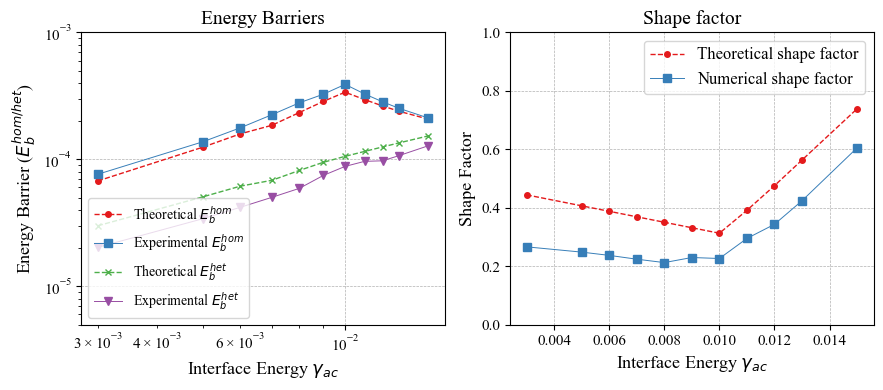

low:0.1809744609150272
 high:0.4008492652575397
[0.40084927 0.38991153 0.38920752 0.3935917  0.39425474 0.30747566
 0.27680673 0.24630915 0.2781872  0.24744484 0.18097446]
[0.2658731385419668, 0.24784844190729766, 0.23668208443984323, 0.2236130616627013, 0.21201084115891283, 0.2293986883534423, 0.22599789835238387, 0.29467899231661526, 0.3430054436118797, 0.4236744433995809, 0.6046711987775776]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pylab as pylabs
from matplotlib.ticker import ScalarFormatter
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
myparams = {

   'axes.labelsize': '13',

   'xtick.labelsize': '11',

   'ytick.labelsize': '11',

   'lines.linewidth': 1,

   'legend.fontsize': '10',

   'font.family': 'Times New Roman',

   'figure.figsize': '9, 4'  #

}
pylabs.rcParams.update(myparams)  

plt.figure()

plt.subplot(1,2,1)

plt.plot(g_ca, theo_hom, 'o--',  markersize=4, label='Theoretical $E_{b}^{hom}$')
plt.plot(g_ca, eb_hom, 's-',  markersize=6, linewidth=0.7, label='Experimental $E_{b}^{hom}$')
plt.plot(g_ca, theo_het, 'x--',  markersize=4, label='Theoretical $E_{b}^{het}$')
plt.plot(g_ca, eb_het, 'v-',  markersize=6, linewidth=0.7, label='Experimental $E_{b}^{het}$')

plt.xlabel('Interface Energy $\\gamma_{ac}$')
plt.ylabel('Energy Barrier ($E_{b}^{hom / het}$)')
plt.title("Energy Barriers", fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.legend(loc='lower left', frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.yscale('log', base=10)
plt.xscale('log', base=10)
plt.ylim(5e-6, 1e-3)

interface_energy_vector = np.array(g_ca)
numerical_shape_factor_vector = np.array(eb_het)/np.array(eb_hom)
theoretical_shape_factor_vector = np.array(sf)

plt.subplot(1,2,2)
plt.plot(interface_energy_vector, theoretical_shape_factor_vector,  "o--", markersize=4, label='Theoretical shape factor')
plt.plot(interface_energy_vector, numerical_shape_factor_vector, "s-", linewidth=0.7, markersize=6, label='Numerical shape factor')
plt.legend(fontsize=12)
plt.title("Shape factor", fontsize=14)
plt.xlabel('Interface Energy $\\gamma_{ac}$')
plt.ylabel('Shape Factor')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("/home/ms/akrito/string-method-nucleation/correction/3d/nonsym/results.pdf", dpi=1000, bbox_inches='tight')
plt.show()

relative_err = np.abs(numerical_shape_factor_vector - theoretical_shape_factor_vector)/theoretical_shape_factor_vector
print(f"low:{np.min(relative_err)}\n high:{np.max(relative_err)}")
print(relative_err)

print(list(numerical_shape_factor_vector))